<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 外れ値なしフィッティング

### 陽関数の場合

2次関数+正規分布誤差で検証

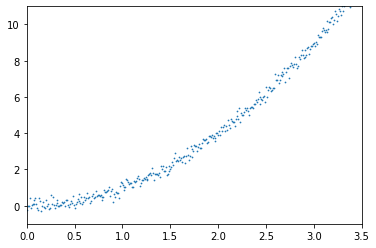

In [114]:
import numpy as np
import matplotlib.pyplot as plt

point_num: int = 1000

# 誤差
errors = np.random.normal(0, 2, (point_num,))
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

陽関数フィッティング。
代表的な Python ライブラリを使う方法は以下の3つ：
1. [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)
2. [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
3. [scipy.optimize.leastsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html)

それぞれを使った方法を示す。

#### numpy.polyfit を使う方法

多項式フィッティングを行う場合に簡便である。

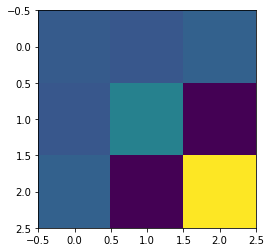

In [115]:
params, cov_mat = np.polyfit(points[:, 0], points[:, 1], deg=2, cov=True)
# 誤差共分散行列を可視化
plt.imshow(cov_mat)

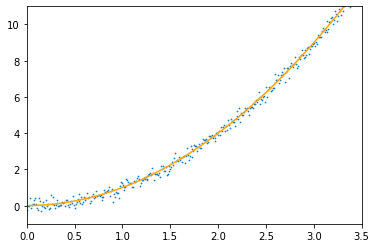

In [116]:
def quad_func(x, a, b, c):
    return a*x**2+b*x+c

plt.scatter(x, y, s=0.5)
plt.plot(x, quad_func(x, *params), color="orange")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

#### scipy.optimize.curve_fit を使う方法

numpy.polyfit と比較して、多項式以外のフィッティングが可能である。

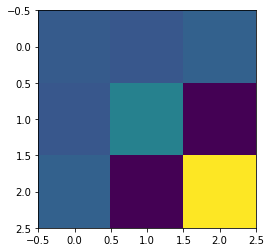

In [117]:
import scipy.optimize as spo

p_opt, p_cov = spo.curve_fit(quad_func, x, y)
# 誤差共分散行列の可視化
plt.imshow(p_cov)

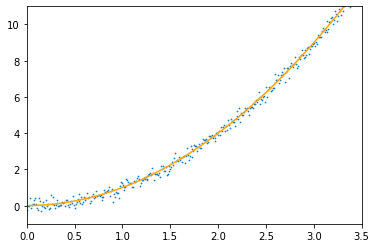

In [118]:
plt.scatter(x, y, s=0.5)
plt.plot(x, quad_func(x, *p_opt), color="orange")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

#### scipy.optimize.leastsq を使う方法

フィッティングの損失関数の設定が可能である。

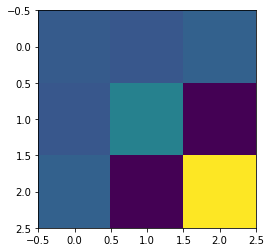

In [119]:
def loss_func(params, points):
    y_est = quad_func(points[:, 0], *params)
    return y_est - points[:, 1]

result = spo.leastsq(loss_func, (0, 0, 0), args=(points), full_output=True)
params = result[0]
cov_mat = result[1]

plt.imshow(cov_mat)

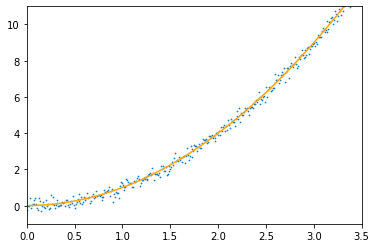

In [120]:
plt.scatter(x, y, s=0.5)
plt.plot(x, quad_func(x, *params), color="orange")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

### 陰関数の場合

円+正規分布誤差で検証

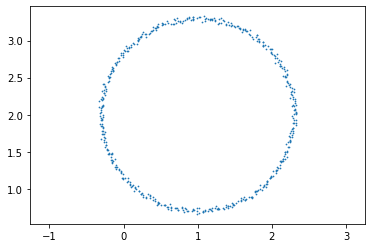

In [121]:
# 点数
point_num = 500
# 誤差
errors = 0.02 * np.random.normal(0, 1, (point_num, 2))
# 媒介変数表示
theta = np.linspace(0, 2*np.pi, point_num)

radius, center = 1.3, (1, 2)
x = radius*np.cos(theta) + center[0] + errors[:, 0]
y = radius*np.sin(theta) + center[1] + errors[:, 1]

points = np.vstack([x, y]).T

plt.scatter(points[:, 0], points[:, 1], s=0.5)
plt.axis("equal")
plt.show()

[ODR (Orthogonal Distance Regression)](https://pota.hatenablog.jp/entry/2014/10/31/033326)を実施

Beta: [ 1.00002655  1.99959655 -1.30155982]
Beta Std Error: [0.00121594 0.00121591 0.00085979]
Beta Covariance: [[ 4.00069940e-03 -3.24008461e-06  6.85028312e-06]
 [-3.24008461e-06  4.00051645e-03  3.48516969e-06]
 [ 6.85028312e-06  3.48516969e-06  2.00030999e-03]]
Residual Variance: 0.00036956000705769623
Inverse Condition #: 0.07299435936215755
Reason(s) for Halting:
  Parameter convergence


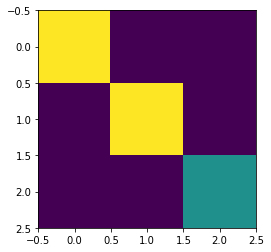

In [122]:
from scipy import odr

def circ_func(beta, x):
    return (x[0]-beta[0])**2+(x[1]-beta[1])**2-beta[2]**2

model = odr.Model(circ_func, implicit=True)
data = odr.Data(points.T, y=1)
solver = odr.ODR(data, model, beta0=[0, 0, 1])
result = solver.run()

result.pprint()
# 誤差共分散行列を可視化
plt.imshow(result.cov_beta)

推定結果の陰関数のヒートマップを作成(0となる部分空間が推定ライン)

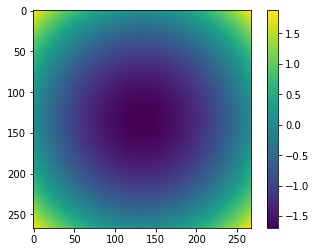

In [123]:
diff=0.01
x_range=np.arange(np.min(points[:, 0]), np.max(points[:, 0]), diff)
y_range=np.arange(np.min(points[:, 1]), np.max(points[:, 1]), diff)
X, Y=np.meshgrid(x_range, y_range)

Z = circ_func(result.beta, (X, Y))

plt.imshow(Z)
plt.colorbar()

(-0.33380244260762715,
 2.464403400635626,
 0.6605334445960355,
 3.461576277876608)

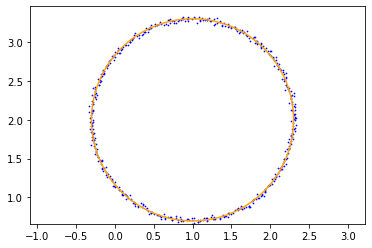

In [124]:
plt.scatter(points[:, 0], points[:, 1], s=0.5, color="blue")
plt.contour(X, Y, Z, [0], colors="orange")
plt.axis("equal")

## RANSAC

### RANSAC (陽関数)

#### 直線フィッティング

誤差分布として外れ値が大きいコーシー分布を仮定

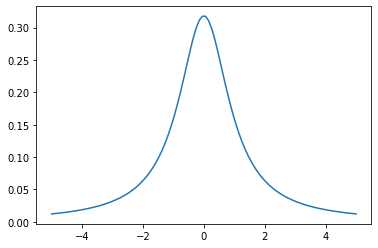

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

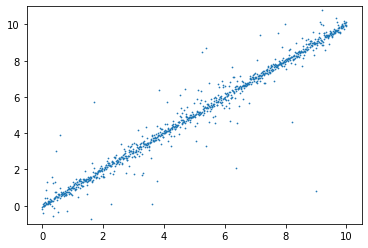

In [126]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

iteration の回数の目安は以下の通り：

1. データ分布から、1回のサンプリングで inlier を引き当てる確率 $e$ を仮定
2. 1回の試行でのサンプル数を $n$ とすると、それらのサンプルが全て inlier である確率は $e^n$
3. 一方で$N$回の試行で 2. が1回も生じない場合(RANSAC が失敗する場合)の確率は$(1-e^n)^N$
4. つまり RANSAC をほぼ確実(確率$p\sim1$)で成功させたい場合は
\begin{equation}
1-p=(1-e^n)^N⇔N=\frac{\ln(1-p)}{\ln(1-e^n)}
\end{equation}
くらいの$N$に設定して反復する。
4. 更に早期終了を目指す場合は、最大の inlier 数更新のタイミングで $e\sim$  (inlier とした数)/(データ数) として$N$を更新

In [127]:
# データの目視確認より 9/10 は対象データと想定
e = 9/10
# 直線のパラメータは2個 → サンプリング数は2個で十分
n = 2
# 99.99% の確率で RANSAC を成功させる
p = 0.9999
# zero division error 対策
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

5


乱数生成

In [128]:
index_mat = np.random.randint(0, point_num, (max_iteration, 2))
print(index_mat)

[[600 807]
 [638 799]
 [762 117]
 [761 984]
 [669 356]]


ランダムサンプリング

In [129]:
np.array([x[index_mat], y[index_mat]]).shape

(2, 5, 2)

In [130]:
# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)

print(samples_tensor.shape)
print(samples_tensor)

(5, 2, 2)
[[[6.00600601 5.9764497 ]
  [8.07807808 8.14789445]]

 [[6.38638639 6.41433771]
  [7.997998   8.04870293]]

 [[7.62762763 7.6576036 ]
  [1.17117117 0.49194434]]

 [[7.61761762 6.87050258]
  [9.84984985 9.97067782]]

 [[6.6966967  6.6909204 ]
  [3.56356356 3.54182021]]]


numpy.polyfit で傾きと切片計算

In [131]:
params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1) 
                          for sample in samples_tensor])

inlier の数を計算 → 最も良い候補を選択

In [132]:
def polynomial(params, points):
    max_degree = len(params)
    # shape=(params, points)
    terms = np.array([params[degree] * points[:, 0] ** (max_degree - degree - 1)
                      for degree in range(max_degree)])
    return np.sum(terms, axis=0)

def get_distances(params, points):
    y_est = polynomial(params, points)
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

4


結果を確認

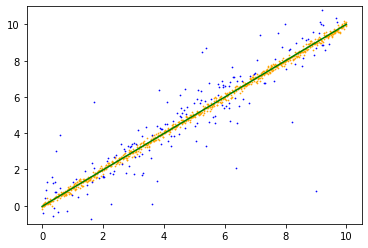

In [133]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(params, points), color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

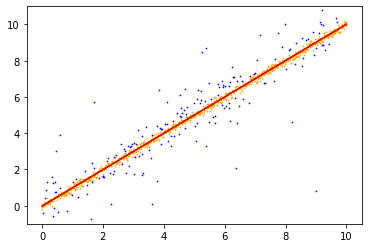

In [134]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.ylim(-1, 11)
plt.show()

#### 2次曲線フィッティング

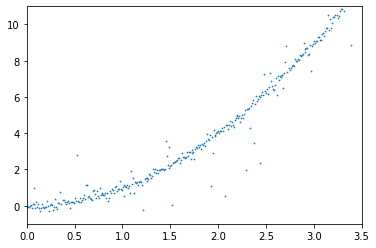

In [135]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

In [136]:
e = 6/10
n = 3
p = 0.9999
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

37


In [137]:
index_mat = np.random.randint(0, point_num, (max_iteration, 3))

# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)
print(samples_tensor.shape)

(37, 3, 2)


In [138]:
params_tensor = np.array([
    np.polyfit(sample[:, 0], sample[:, 1], 2)
    for sample in samples_tensor])

In [139]:
def get_distances(params, points):
    y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

13


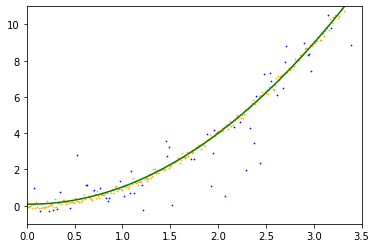

In [140]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
plt.plot(points[:, 0], y_est, color="green")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

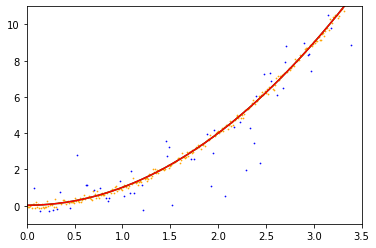

In [141]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 2)
y_refined =  refined_params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")


plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

### RANSAC (陰関数)

#### 円の例

基底関数を定義

In [142]:
def linear_basis(point):
    x, y = point
    return [x, y, 1]

def quad_basis(point):
    x, y = point
    return [x**2, 2*x*y, y**2, 2*x, 2*y, 1]

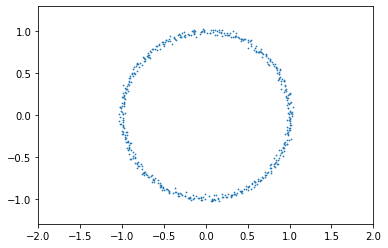

In [143]:
# 点数
point_num = 500
# 誤差
errors = 0.02 * np.random.normal(0, 1, (point_num, 2))
# 媒介変数表示
theta = np.linspace(0, 2*np.pi, point_num)
x = np.cos(theta) + errors[:, 0]
y = np.sin(theta) + errors[:, 1]

points = np.vstack([x, y]).T

plt.scatter(points[:, 0], points[:, 1], s=0.5)
plt.axis("equal")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

構造行列の計算例

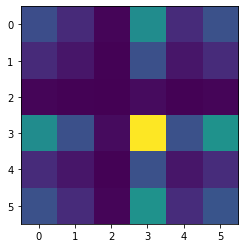

In [144]:
xi=quad_basis(points[20])
mat=np.outer(xi, xi)

plt.imshow(mat)

誤差がある系だと正定値行列。誤差がない系だと det=0 で非負定値。

det=0.00042184003232809066
Matrix is positive definite
e_value=[5.47873861e-04 2.53306684e-01 1.50370430e+00 5.01886557e-01
 2.02006965e+00 1.99382122e+00]
params=[ 0.5741607   0.00085856  0.57900436 -0.00087985  0.0008365  -0.57887065]


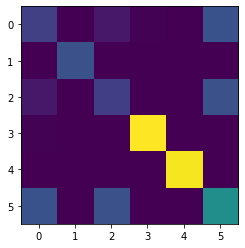

In [145]:
xi_list = np.array([quad_basis(point) for point in points])
structure_mat = np.mean(np.array([np.outer(xi, xi) for xi in xi_list]), 0)
plt.imshow(structure_mat)

print(f"det={np.linalg.det(structure_mat)}")
# 正定値性の確認(正定値でないと cholesky 分解でエラー)
try:
    np.linalg.cholesky(structure_mat)
except np.linalg.LinAlgError as e:
    print(e)
else:
    print("Matrix is positive definite")

e_value, e_vec = np.linalg.eig(structure_mat)
print(f"e_value={e_value}")

# 固有ベクトルは列毎に格納されていることに注意
params=e_vec[:, np.argmin(e_value)]
print(f"params={params}")

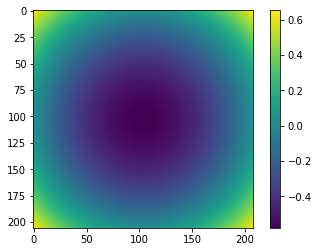

In [146]:
diff=0.01
x_range=np.arange(np.min(points[:, 0]), np.max(points[:, 0]), diff)
y_range=np.arange(np.min(points[:, 1]), np.max(points[:, 1]), diff)
X, Y=np.meshgrid(x_range, y_range)

basises=np.array([basis*np.ones_like(X) for basis in quad_basis((X, Y))])
Z=np.einsum("i,ijk->jk", params, basises)
plt.imshow(Z)
plt.colorbar()

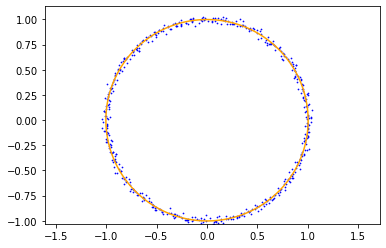

In [147]:
plt.scatter(points[:, 0], points[:, 1], s=0.5, color="blue")
plt.contour(X, Y, Z, [0], colors="orange")
plt.axis("equal")
plt.show()

#### RANSAC クラスの作成

自動微分を実施するための Jet を定義

In [148]:
class Jet:
    def __init__(self, a: float, v):
        self.a = a
        self.v = np.array(v)

    def __str__(self):
        return f"{self.a}+{self.v}"

    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a + other.a, self.v + other.v)

    def __sub__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeors(len(self.v)))
        return Jet(self.a - other.a, self.v - other.v)
    
    def __mul__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a * other.a, self.a * other.v + self.v * other.a)
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a / other.a, self.v / other.a - self.a * other.v / other.a ** 2)
    
    def __pow__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        value = self.a ** other.a
        base_diff = other.a * self.a ** (other.a - 1) * self.v
        # 底が0, 負の場合に注意
        if np.isclose(self.a, 0):
            exp_diff = 0
        else:
            exp_diff = value * other.v * np.log(np.abs(self.a))
        return Jet(value, base_diff + exp_diff)

    def __radd__(self, other):
        return self.__add__(other)
    
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)
        

x = Jet(1, (1, 0))
y = Jet(2, (0, 1))
print(quad_basis((x, y))[1])

4+[4. 2.]


前セクションまでの処理を踏まえて、RANSAC を行うための一般的なクラスを定義する

In [149]:
from typing import List
import random
import numpy.linalg as LA
from tqdm import tqdm

class RANSAC:
    def __init__(self, basis_func, target_prob=0.9999):
        # 関数: データ点 -> List[基底関数]
        self.basis_func = basis_func
        # RANSAC の目標成功確率
        self.target_prob = target_prob

    def fit(self, points):
        xi_list = np.array([self.basis_func(point) for point in points])
        mat_list = np.array([np.outer(xi, xi) for xi in xi_list])
        mat = np.mean(mat_list, axis=0)

        if not np.isclose(np.linalg.det(mat), 0):
            print("This fitting is statistics mode.")

        e_value, e_vec = LA.eig(mat)
        # 非負定値行列だが行列式が0となることがあるため絶対値をとる(数値誤差のため)
        idx = np.argmin(e_value)
        # 固有ベクトルは列毎に格納されていることに注意
        return e_vec[:, idx], e_value[idx]

    def jet_basis(self, point: np.ndarray) -> List[Jet]:
        """Jet 型の基底関数

        :param point: データ値(規格化済)
        :return:
        """
        jets = [Jet(point[idx], np.eye(len(point))[idx])
                for idx in range(len(point))]
        basis_list = self.basis_func(jets)
        return [basis + Jet(0, np.zeros_like(point)) for basis in basis_list]

    def get_cov_mat(self, point: np.ndarray) -> np.ndarray:
        """正規化共分散行列

        :param point: データ値(規格化済)
        :return: 正規化共分散行列
        """
        xi = self.jet_basis(point)
        return np.array([[np.dot(xi[i].v, xi[j].v) 
                         for j in range(len(xi))] 
                         for i in range(len(xi))])
        
    def sampson_error(self, point: np.ndarray, params: np.ndarray):
        cov_mat = self.get_cov_mat(point)
        denominator = np.dot(params, cov_mat @ params)

        xi = self.basis_func(point)
        numerator = np.dot(xi, params) ** 2

        return numerator/denominator if not np.isclose(denominator, 0) else np.inf

    def criteria(self, inlier_prob: float, degree: int) -> int:
        """RANSAC の終了条件を計算

        :param inlier_prob: inlier の割合/確率
        :param degree: フィッティング次数/サンプル数
        :return: RANSAC の反復回数の目安
        """
        # zero division error 対策
        return int(np.log(1-self.target_prob)/_) \
            if not np.isclose((_ := np.log(1-inlier_prob**degree)), 0) else 1e+5

    def execute(self, points, distance_th=0.1):
        data_num = points.shape[0]
        # パラメータは規格化するのでその拘束条件で -1
        degree = len(self.basis_func(points[0, :]))-1
        # 最悪のケースとして inlier がデータの 1/10 と仮定
        inlier_prob = 0.1
        max_iteration = self.criteria(inlier_prob, degree)

        iteration=0
        best_inlier_bool = [False for _ in range(data_num)]
        best_inlier_num = 0
        best_params = []
        with tqdm(total=max_iteration) as pbar:
            while(iteration < max_iteration):
                # ランダムサンプリング
                rand_idx = random.sample(range(data_num), degree)
                # フィッティング
                params, _ = self.fit(points[rand_idx, :])
                distance_sq = np.array([self.sampson_error(point, params) 
                                         for point in points])
                # inlier 判定
                inlier_bool = distance_sq < (distance_th ** 2)
                inlier_num = np.sum(inlier_bool)

                iteration += 1
                pbar.update(1)

                if inlier_num > best_inlier_num:
                    # 繰り返し回数の再判定
                    max_iteration = min(
                        max_iteration, self.criteria(inlier_num/data_num, degree))
                    
                    best_inlier_bool = inlier_bool
                    best_inlier_num = inlier_num
                    best_params = params
                    pbar.total = max_iteration
                    pbar.refresh()
                    
        best_params, loss = self.fit(points[best_inlier_bool, :])
        print(f"params={best_params}")
        print(f"fitness={best_inlier_num/data_num}")
        return best_params, best_inlier_bool, loss

#### 線形フィッティング

実装の確認のために再度線形フィッティングを実施。
上と同様にサンプルデータを生成。

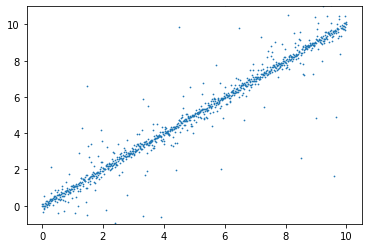

In [150]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

In [151]:
linear_estimator = RANSAC(linear_basis)
params, inlier_bools, loss = linear_estimator.execute(points, distance_th=0.3)

100%|██████████| 7/7 [00:01<00:00,  6.65it/s]

This fitting is statistics mode.
params=[ 0.7098957  -0.70149    -0.06292752]
fitness=0.829


陰関数プロットのためのヘルパー関数を定義

In [152]:
def get_contour(basis_func, points, params, diff):
    # グリッド生成
    x_range=np.arange(np.min(points[:, 0]), np.max(points[:, 0]), diff)
    y_range=np.arange(np.min(points[:, 1]), np.max(points[:, 1]), diff)
    x_mesh, y_mesh=np.meshgrid(x_range, y_range)

    basises=np.array([basis*np.ones_like(x_mesh) 
                      for basis in basis_func((x_mesh, y_mesh))])
    z_mesh=np.einsum("i,ijk->jk", params, basises)
    return x_mesh, y_mesh, z_mesh

結果をプロット

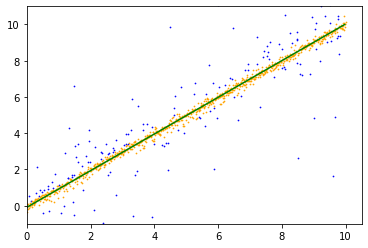

In [153]:
inlier_idx = np.arange(point_num)[inlier_bools]
outlier_idx = np.arange(point_num)[~inlier_bools]

plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")
plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")

plt.contour(*get_contour(linear_basis, points, params, 0.01), [0], colors="green")
plt.ylim(-1, 11)
plt.show()

#### 2次曲線フィッティング

サンプルデータ生成


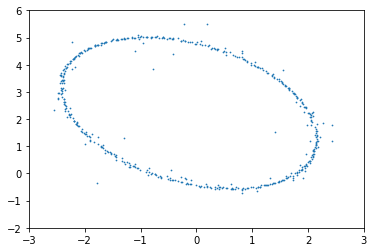

In [154]:
# データ中心
center = np.array([1, 2])
# 軸半径
scales = np.array([2, 3])
# 回転角
rad = np.deg2rad(-30)

# 点数
point_num = 500
# 誤差
errors = 0.01 * np.random.standard_cauchy((point_num, 2))
# 媒介変数表示
theta = np.linspace(0, 2*np.pi, point_num)
x = center[0] + scales[0]*np.cos(theta) + errors[:, 0]
y = center[1] + scales[1]*np.sin(theta) + errors[:, 1]

points = np.vstack([x, y]).T
# 回転行列
rot_mat = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
points = points @ rot_mat

plt.scatter(points[:, 0], points[:, 1], s=0.5)
plt.xlim((-3, 3))
plt.ylim((-2, 6))
plt.show()

In [155]:
quad_estimator = RANSAC(quad_basis)
params, inlier_bools, loss = quad_estimator.execute(points, distance_th=0.07)

100%|██████████| 14/14 [00:01<00:00,  7.10it/s]

This fitting is statistics mode.
params=[-0.41023945 -0.11462171 -0.27775501  0.20178146  0.60576383  0.57771276]
fitness=0.858


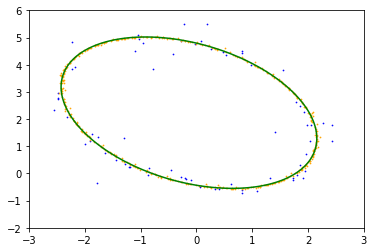

In [156]:
inlier_idx = np.arange(point_num)[inlier_bools]
outlier_idx = np.arange(point_num)[~inlier_bools]

plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")
plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")

plt.contour(*get_contour(quad_basis, points, params, 0.01), [0], colors="green")
plt.xlim((-3, 3))
plt.ylim((-2, 6))
plt.show()

誤差共分散行列
\begin{equation}
V\equiv E[\delta a^T\delta a]
=\frac{\chi^2}{n-m}(X^TX)^{-1}
\end{equation}

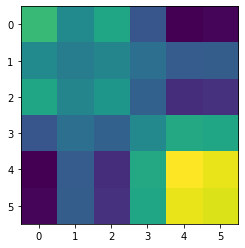

In [167]:
basis_list = np.array([quad_basis(point) for point in points[inlier_idx, :]])
param_cov = np.linalg.inv(basis_list.T @ basis_list) * loss / (np.sum(inlier_bools)-basis_list.shape[1]) * np.sum(inlier_bools)
plt.imshow(param_cov)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


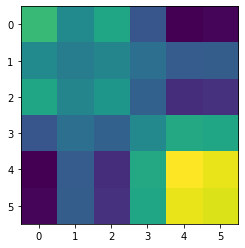

In [158]:
model = odr.Model(lambda beta, x: np.dot(beta, quad_basis(x)), implicit=True)
data = odr.Data(points[inlier_idx, :].T, y=1)
solver = odr.ODR(data, model, beta0=[0, 0, 0, 0, 0, 1])
result = solver.run()

# result.pprint()
plt.imshow(result.cov_beta)

In [168]:
print(param_cov / result.cov_beta)

[[1.32222252 1.32222239 1.32222257 1.32222239 1.32222256 1.32222261]
 [1.32222239 1.32222225 1.32222243 1.32222225 1.32222243 1.32222247]
 [1.32222257 1.32222243 1.32222261 1.32222243 1.32222261 1.32222265]
 [1.32222239 1.32222225 1.32222243 1.32222224 1.32222243 1.32222247]
 [1.32222256 1.32222243 1.32222261 1.32222243 1.3222226  1.32222265]
 [1.32222261 1.32222247 1.32222265 1.32222247 1.32222265 1.32222268]]
